/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1: Accuracy=0.3411, Loss=1.2748, F1 Score=0.3059
Epoch 2: Accuracy=0.8337, Loss=0.5875, F1 Score=0.8350
Epoch 3: Accuracy=0.8557, Loss=0.4044, F1 Score=0.8545
Epoch 4: Accuracy=0.8595, Loss=0.4840, F1 Score=0.8581
Epoch 5: Accuracy=0.8524, Loss=0.5619, F1 Score=0.8480
Epoch 6: Accuracy=0.8578, Loss=0.5751, F1 Score=0.8553
Epoch 7: Accuracy=0.8621, Loss=0.5984, F1 Score=0.8595
Epoch 8: Accuracy=0.8623, Loss=0.6397, F1 Score=0.8600
Epoch 9: Accuracy=0.8614, Loss=0.6439, F1 Score=0.8591
Epoch 10: Accuracy=0.8583, Loss=0.6841, F1 Score=0.8560
Epoch 11: Accuracy=0.8571, Loss=0.6537, F1 Score=0.8544
Epoch 12: Accuracy=0.8604, Loss=0.6751, F1 Score=0.8581
Epoch 13: Accuracy=0.8627, Loss=0.6836, F1 Score=0.8604
Epoch 14: Accuracy=0.8643, Loss=0.6908, F1 Score=0.8620
Epoch 15: Accuracy=0.8601, Loss=0.7597, F1 Score=0.8570
Epoch 16: Accuracy=0.8627, Loss=0.7259, F1 Score=0.8610
Epoch 17: Accuracy=0.8617, Loss=0.7377, F1 Score=0.8596
Epoch 18: Accuracy=0.8615, Loss=0.7651, F1 Score=0.8590
E

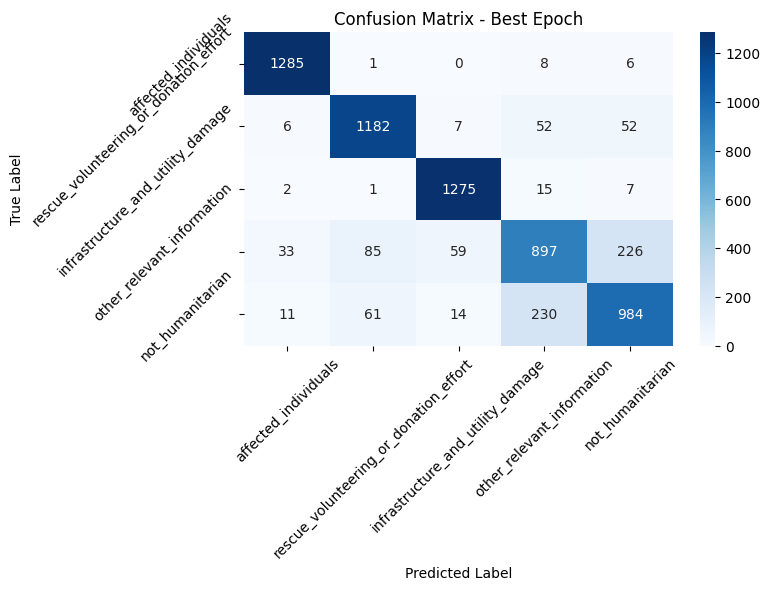

✅ Model saved to /kaggle/working/tfidf_cnn_humanitarian_best_model.h5
Saved artifact at '/tmp/tmp6t0t_wix'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 5003), dtype=tf.float32, name='keras_tensor_72')
Output Type:
  TensorSpec(shape=(None, 5), dtype=tf.float32, name=None)
Captures:
  138114676577424: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138114676577232: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138114676575312: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138114676573392: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138114676576464: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138114676573008: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138114676572432: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138114676580496: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138114676576272: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138114676573776: T

W0000 00:00:1747743013.139820      91 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1747743013.139848      91 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.


In [5]:
# ========== Imports ==========
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import Callback
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

# ========== Load Data ==========
file_path = "/kaggle/input/mergefile/Merged_Disasters(2).csv"
df = pd.read_csv(file_path)
df.columns = df.columns.str.strip().str.lower()

# ========== Check for Required Columns ==========
if 'processed_data' not in df.columns or 'humanitarian_class' not in df.columns:
    raise ValueError("Missing 'processed_data' or 'humanitarian_class' columns.")

# ========== Preprocess ==========
df['processed_data'] = df['processed_data'].fillna("")
df['humanitarian_class'] = df['humanitarian_class'].fillna('not_humanitarian').str.strip().str.lower()

# ========== Label Encoding ==========
label_map = {
    'affected_individuals': 0,
    'rescue_volunteering_or_donation_effort': 1,
    'infrastructure_and_utility_damage': 2,
    'other_relevant_information': 3,
    'not_humanitarian': 4
}
df['label'] = df['humanitarian_class'].map(label_map)

# ========== Handcrafted Features ==========
df['tweet_length'] = df['processed_data'].apply(len)
df['num_hashtags'] = df['processed_data'].apply(lambda x: x.count("#"))
df['num_mentions'] = df['processed_data'].apply(lambda x: x.count("@"))

# ========== TF-IDF Vectorization ==========
vectorizer = TfidfVectorizer(max_features=5000, stop_words='english', ngram_range=(1, 2))
X_text = vectorizer.fit_transform(df['processed_data'])

# ========== Scale Handcrafted Features ==========
scaler = StandardScaler()
X_hand = scaler.fit_transform(df[['tweet_length', 'num_hashtags', 'num_mentions']])

# ========== Combine Features ==========
X_combined = np.hstack((X_text.toarray(), X_hand))
y = df['label'].values

# ========== Apply SMOTE to Entire Dataset ==========
smote = SMOTE(random_state=42, k_neighbors=3)
X_resampled, y_resampled = smote.fit_resample(X_combined, y)

# ========== Train-Test Split (Stratified) ==========
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.2, stratify=y_resampled, random_state=42
)

# ========== Build CNN-like Dense Model ==========
def create_model(input_dim, num_classes):
    model = Sequential([
        Dense(512, activation='relu', input_dim=input_dim),
        Dropout(0.5),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# ========== Callback to Monitor F1 Score Per Epoch ==========
class TestMetricsLogger(Callback):
    def __init__(self, X_test, y_test):
        self.X_test = X_test
        self.y_test = y_test
        self.best_f1 = 0
        self.best_metrics = {}

    def on_epoch_end(self, epoch, logs=None):
        y_pred = np.argmax(self.model.predict(self.X_test, verbose=0), axis=1)
        acc = accuracy_score(self.y_test, y_pred)
        f1 = f1_score(self.y_test, y_pred, average='weighted')
        loss = self.model.evaluate(self.X_test, self.y_test, verbose=0)[0]
        print(f"Epoch {epoch + 1}: Accuracy={acc:.4f}, Loss={loss:.4f}, F1 Score={f1:.4f}")
        if f1 > self.best_f1:
            self.best_f1 = f1
            self.best_metrics = {
                "epoch": epoch + 1,
                "accuracy": acc,
                "loss": loss,
                "f1_score": f1,
                "y_pred": y_pred.copy()
            }

# ========== Train Model ==========
model = create_model(X_train.shape[1], len(label_map))
logger = TestMetricsLogger(X_test, y_test)
model.fit(X_train, y_train, epochs=20, batch_size=128, verbose=0, callbacks=[logger])

# ========== Final Evaluation with Best Epoch ==========
model.set_weights(model.get_weights())  # Ensure best weights are used (implicitly updated by callback)
best = logger.best_metrics
print(f"\n✅ Best Epoch: {best['epoch']} | Accuracy={best['accuracy']:.4f}, Loss={best['loss']:.4f}, F1 Score={best['f1_score']:.4f}")

# ========== Final Classification Report ==========
print("\n📋 Final Test Classification Report:\n")
print(classification_report(y_test, best['y_pred'], target_names=label_map.keys()))

# ========== Confusion Matrix ==========
cm = confusion_matrix(y_test, best['y_pred'])
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=label_map.keys(), yticklabels=label_map.keys())
plt.title("Confusion Matrix - Best Epoch")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.tight_layout()
plt.show()

# ========== Save Final Model ==========
model.save("/kaggle/working/tfidf_cnn_humanitarian_best_model.h5")
print("✅ Model saved to /kaggle/working/tfidf_cnn_humanitarian_best_model.h5")

# ========== Convert to TFLite ==========
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open("/kaggle/working/tfidf_cnn_humanitarian_best_model.tflite", "wb") as f:
    f.write(tflite_model)

print("✅ Model converted and saved to /kaggle/working/tfidf_cnn_humanitarian_best_model.tflite")